# Using LSTM(Window Regression Approach) On Air Passenger Dataset


In [1]:

import pandas as pd
import numpy as np
import sklearn 
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from pandas import datetime
import keras
from keras import Sequential
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.recurrent import LSTM
from sklearn.metrics import mean_squared_error
from sklearn.utils import shuffle
%matplotlib inline

Using TensorFlow backend.


In [2]:
dataframe = pd.read_csv("../datasets/AirPassengers.csv")
dataframe

,Month,#Passengers
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121
5,1949-06,135
6,1949-07,148
7,1949-08,148
8,1949-09,136
9,1949-10,119


In [3]:
print dataframe.head()
print '\n Data Types:'
print dataframe.dtypes

# The data contains a particular month and number of passengers travelling in that month. 
#But this is still not read as a TS object as the data types are ‘object’ and ‘int’. 
#In order to read the data as a time series, we have to pass special arguments to the read_csv command:

dateparse = lambda dates: pd.datetime.strptime(dates, '%Y-%m')
data = pd.read_csv('../datasets/AirPassengers.csv', parse_dates=['Month'], header=0, index_col='Month',date_parser=dateparse)

     Month  #Passengers
0  1949-01          112
1  1949-02          118
2  1949-03          132
3  1949-04          129
4  1949-05          121

 Data Types:
Month          object
#Passengers     int64
dtype: object


In [4]:
print "data ", data.describe()

data         #Passengers
count   144.000000
mean    280.298611
std     119.966317
min     104.000000
25%     180.000000
50%     265.500000
75%     360.500000
max     622.000000


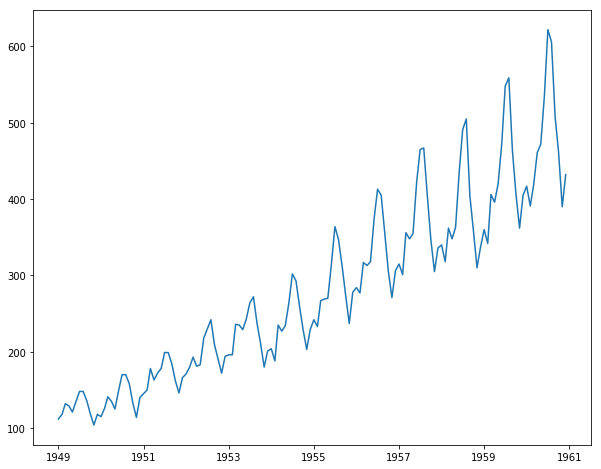

In [5]:
plt.figure(figsize=(10,8))
plt.plot(data['#Passengers'])

In [6]:
# Check whether dataset is incomplete
data.isnull().values.any()

False

## Prepare the dataset

This includes:

i. Normalization of the feature values

ii. Convert the dataset in the time series(up to certain steps)

iii. Split the dataset into training and test 

### 1. Normalization 

In [7]:
# Preparing the dataset
# normalize the values between 0 and 1
# .fit_Transform function is used to find minimum and maximum values in the data and normalize according to that.
# Since we are normalizing values b/w 0 and 1. 
# So after predictions, we have transform again into original form. If needed, the transform can be inverted. 
# This is useful for converting predictions back into their original scale for reporting or plotting. 
# This can be done by calling the inverse_transform() function
# print dataframe.values.reshape(dataframe.shape[0],1)
# print dataframe["#Passengers"].shape

# 
scaler = preprocessing.MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(data.values.reshape(dataframe.shape[0],1))
scaled_dataframe = pd.DataFrame(scaled_data, columns=["t"])
scaled_dataframe

/home/ramesh/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


,t
0,0.015444
1,0.027027
2,0.054054
3,0.048263
4,0.032819
5,0.059846
6,0.084942
7,0.084942
8,0.061776
9,0.028958


### 2. Convert the dataset in the time series

In [8]:

window_size = 8

for i in range(window_size):
    
    scaled_dataframe["t"+ "+" + str(i+1)] = scaled_dataframe["t"].shift(-(i+1))
    
scaled_dataframe

,t,t+1,t+2,t+3,t+4,t+5,t+6,t+7,t+8
0,0.015444,0.027027,0.054054,0.048263,0.032819,0.059846,0.084942,0.084942,0.061776
1,0.027027,0.054054,0.048263,0.032819,0.059846,0.084942,0.084942,0.061776,0.028958
2,0.054054,0.048263,0.032819,0.059846,0.084942,0.084942,0.061776,0.028958,0.000000
3,0.048263,0.032819,0.059846,0.084942,0.084942,0.061776,0.028958,0.000000,0.027027
4,0.032819,0.059846,0.084942,0.084942,0.061776,0.028958,0.000000,0.027027,0.021236
5,0.059846,0.084942,0.084942,0.061776,0.028958,0.000000,0.027027,0.021236,0.042471
6,0.084942,0.084942,0.061776,0.028958,0.000000,0.027027,0.021236,0.042471,0.071429
7,0.084942,0.061776,0.028958,0.000000,0.027027,0.021236,0.042471,0.071429,0.059846
8,0.061776,0.028958,0.000000,0.027027,0.021236,0.042471,0.071429,0.059846,0.040541
9,0.028958,0.000000,0.027027,0.021236,0.042471,0.071429,0.059846,0.040541,0.086873


In [9]:
# Drop NA values 

scaled_dataframe.dropna(axis=0, inplace=True)
scaled_dataframe


,t,t+1,t+2,t+3,t+4,t+5,t+6,t+7,t+8
0,0.015444,0.027027,0.054054,0.048263,0.032819,0.059846,0.084942,0.084942,0.061776
1,0.027027,0.054054,0.048263,0.032819,0.059846,0.084942,0.084942,0.061776,0.028958
2,0.054054,0.048263,0.032819,0.059846,0.084942,0.084942,0.061776,0.028958,0.000000
3,0.048263,0.032819,0.059846,0.084942,0.084942,0.061776,0.028958,0.000000,0.027027
4,0.032819,0.059846,0.084942,0.084942,0.061776,0.028958,0.000000,0.027027,0.021236
5,0.059846,0.084942,0.084942,0.061776,0.028958,0.000000,0.027027,0.021236,0.042471
6,0.084942,0.084942,0.061776,0.028958,0.000000,0.027027,0.021236,0.042471,0.071429
7,0.084942,0.061776,0.028958,0.000000,0.027027,0.021236,0.042471,0.071429,0.059846
8,0.061776,0.028958,0.000000,0.027027,0.021236,0.042471,0.071429,0.059846,0.040541
9,0.028958,0.000000,0.027027,0.021236,0.042471,0.071429,0.059846,0.040541,0.086873


### Split the dataset for training and testing

In [10]:
split_data = int((0.7*scaled_dataframe.shape[0]))
print "split_data ", split_data

train_data = scaled_dataframe.iloc[:split_data,:]
test_data = scaled_dataframe.iloc[split_data:,:]

split_data  95


In [11]:
# Consider last column as output
train_data_x = train_data.iloc[:,:-1]
train_data_y = train_data.iloc[:,-1]

test_data_x = test_data.iloc[:,:-1]
test_data_y = test_data.iloc[:,-1]
print "train features shape ", train_data_x.shape
print "train label shape ", train_data_y.shape
print "test data y ", test_data_y.shape

train features shape  (95, 8)
train label shape  (95,)
test data y  (41,)


# Define Model Parameters

In [12]:
# Reshape it for LSTM 
train_data_x = np.array(train_data_x)
test_data_x = np.array(test_data_x)
# print train_data_x.shape[0], train_data_x.shape[1]
train_data_x = train_data_x.reshape(train_data_x.shape[0],train_data_x.shape[1],1)
test_data_x = test_data_x.reshape(test_data_x.shape[0],test_data_x.shape[1],1)
print "Reshape train example x ", train_data_x.shape
print "Reshape test example x ", test_data_x.shape
# input_shape = (window_size,1)
# output = window_size

Reshape train example x  (95, 8, 1)
Reshape test example x  (41, 8, 1)


In [13]:
batch_size = 1
look_back = 3
input_shape = (batch_size, window_size,1)
output = 1

In [14]:
# 'stateful', which means that the states computed for the samples in one batch will be reused as initial states 
#for the samples in the next batch. 
#This assumes a one-to-one mapping between samples in different successive batches.

# model = Sequential()
# model.add(LSTM(4, input_shape=(look_back, 1), stateful=True, return_sequences=True))
# model.add(LSTM(4, input_shape=(look_back, 1), stateful=True))
# model.add(Dense(1))
# model.compile(loss='mean_squared_error', optimizer='adam')

# LSTM Model  Architecture

In [15]:
model = Sequential()
model.add(LSTM(10, batch_input_shape=(input_shape), return_sequences=True, stateful=True))

# model.add(Dense(128))
# model.add(Dropout(0.5))
model.add(LSTM(4))

model.add(Dropout(0.5))
# model.add(Dense(64))
model.add(Dense(1))
# model.add(Activation(""))
model.compile(loss="mse", optimizer="adam", metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (1, 8, 10)                480       
_________________________________________________________________
lstm_2 (LSTM)                (1, 4)                    240       
_________________________________________________________________
dropout_1 (Dropout)          (1, 4)                    0         
_________________________________________________________________
dense_1 (Dense)              (1, 1)                    5         
Total params: 725
Trainable params: 725
Non-trainable params: 0
_________________________________________________________________


In [16]:
model.fit(train_data_x,train_data_y,batch_size=1,epochs=8,validation_split=0.1, shuffle=False)


Train on 85 samples, validate on 10 samples
Epoch 1/8
85/85 [==============================] - 3s 31ms/step - loss: 0.0149 - acc: 0.0118 - val_loss: 0.0427 - val_acc: 0.0000e+00
Epoch 2/8
85/85 [==============================] - 1s 12ms/step - loss: 0.0308 - acc: 0.0118 - val_loss: 0.0483 - val_acc: 0.0000e+00
Epoch 3/8
85/85 [==============================] - 1s 11ms/step - loss: 0.0246 - acc: 0.0118 - val_loss: 0.0416 - val_acc: 0.0000e+00
Epoch 4/8
85/85 [==============================] - 1s 12ms/step - loss: 0.0214 - acc: 0.0118 - val_loss: 0.0363 - val_acc: 0.0000e+00
Epoch 5/8
85/85 [==============================] - 1s 15ms/step - loss: 0.0162 - acc: 0.0118 - val_loss: 0.0212 - val_acc: 0.0000e+00
Epoch 6/8
85/85 [==============================] - 1s 12ms/step - loss: 0.0135 - acc: 0.0118 - val_loss: 0.0182 - val_acc: 0.0000e+00
Epoch 7/8
85/85 [==============================] - 1s 12ms/step - loss: 0.0105 - acc: 0.0118 - val_loss: 0.0157 - val_acc: 0.0000e+00
Epoch 8/8
85/85 [=

In [18]:
predicted_output = model.predict(test_data_x)
#converting predictions back into their original scale for reporting or plotting.
# print "predicted output shape ", predicted_output.shape
predicted_output_scaled = scaler.inverse_transform(predicted_output)
print predicted_output

ValueError: In a stateful network, you should only pass inputs with a number of samples that can be divided by the batch size. Found: 41 samples. Batch size: 32.

In [ ]:
# convert actual to its original form
# test_data_y = test_data_y.values.reshape(-1,1)
test_data_y = test_data_y.reshape(test_data.shape[0],1)
print test_data_y
actual_output_scaled = scaler.inverse_transform(test_data_y)
# actual_output.shape

In [ ]:
print "mean square error ", mean_squared_error(actual_output_scaled,predicted_output_scaled)

## Conclusion:

Due to less number of training examples, model is unable to learn properly and mean square error is very huge